## Part -1 : Digital content management using NLP

##### DOMAIN: Digital content management
##### CONTEXT: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles,  etc. is written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.
##### DATA DESCRIPTION: Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words per person. Each blog is presented as a separate file, the name of which indicates a blogger id# and the blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for many, industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age groups:
	8240 "10s" blogs (ages 13-17), 
	8086 "20s" blogs(ages 23-27) and 
	2994 "30s" blogs (ages 33-47)

	For each age group, there is an equal number of male and female bloggers. Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been stripped with two exceptions. Individual posts within a single blogger are separated by the date of the following post and links within a post are denoted by the label url link. 
	
	Link to dataset: https://www.kaggle.com/rtatman/blog-authorship-corpus
##### PROJECT OBJECTIVE: The need is to build a NLP classifier which can use input text parameters to determine the label/s of the blog.

Steps and tasks:
	1. Import and analyse the data set.
	2. Perform data pre-processing on the data:
		• Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.
		• Target/label merger and transformation
		• Train and test split
		• Vectorisation, etc.
	3. Design, train, tune and test the best text classifier.
	4. Display and explain detail the classification report
	5. Print the true vs predicted labels for any 5 entries from the dataset.

Hint: The aim here Is to import the text, process it such a way that it can be taken as an inout to the ML/NN classifiers. Be analytical and experimental here in trying new 
approaches to design the best model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive



### Task #1 :: Import and analyse the data set.

The data set provided is around 800 MB and there are many text records to be processed. This data may not fit into memory and processing will take more time and needs some mechanism to process the data parallely. There are several ways to handle data which doesn't fit to memory.

Modin is a python library that can be used to handle large datasets using parallelisation.  Dask is one more framework which can be used in this use case. Here modin is using dask as underlying framework.

Note: There are several other ways like using python pool which brings in some kind of parallelism but here we need to take care of releasing the utilized back. In Pandas release memory back is not working as expected. We shall see the same in this notebook and we would add appropriate explanation and **comment** the code.


In [ ]:
## Uncomment if starting new runtime/instance in colab
!pip install modin[dask]
!pip install dateparser
!pip install emoji --quiet

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 212 µs (started: 2021-10-31 10:53:29 +00:00)


In [ ]:
### instead of using pandas we are using modin and hence commenting pandas import statement

# import pandas as pd
import modin.pandas as pd
import os
import numpy as np
os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

from nltk import WordNetLemmatizer
import re
import unicodedata
import emoji
from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

time: 30.1 ms (started: 2021-10-31 10:53:58 +00:00)


In [ ]:
blog_df = pd.read_table('/content/drive/MyDrive/MachineLearning/NLP/Project/Week3Project/blogtext_1.csv', header='infer', sep=',')

time: 10.5 s (started: 2021-10-31 10:53:59 +00:00)


In [ ]:
### considering entire dataset
blog_df = blog_df

#considering only subset of data - for testing the flow
# blog_df = blog_df.iloc[0:20000]

time: 1.43 ms (started: 2021-10-31 10:54:09 +00:00)


  Checking the basic information on dataframe which is created from the blog dataset

In [ ]:
blog_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  ---------------  ----- 
 0   id      681284 non-null  int64
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: object(5), int64(2)
memory usage: 36.4 MB
time: 3.19 s (started: 2021-10-31 10:54:09 +00:00)


  There are 681284 blog in the dataset. Id column is of int datatype and looks like it can be ignored from analysis. Gender, topic and sign are of object data type and needs to be looked into as it is required to predict the lable/s. Text column is out input column which needs to be processed.


  Lets check few sample data.

In [ ]:
blog_df.sample(10)

,id,gender,age,topic,sign,date,text
622701,1651222,female,38,indUnk,Virgo,"22,December,2002","Damn, Joe Strummer is dead."
122873,3294192,male,16,Student,Sagittarius,"09,June,2004","Check this shit, it is amazin..."
385785,3393874,female,24,Communications-Media,Libra,"18,June,2004","Yesterday, I drove around the area ..."
326292,861706,male,24,indUnk,Sagittarius,"17,October,2003",Looks like I have another fan may...
64941,2539230,female,16,Student,Cancer,"02,June,2004",Omg dude we had the worst thundestorm e...
124474,1304830,female,14,Education,Libra,"25,January,2004","who knows... Mitch, who are u?"
431567,183163,male,27,Arts,Sagittarius,"18,June,2004","yesterday, i woke up to the s..."
588338,1078410,male,16,indUnk,Cancer,"05,January,2004",urlLink Phantom unveiling at CES -...
28864,3737788,female,24,Publishing,Pisces,"27,Junho,2004","Feeling molto relaxed today, after ..."
436999,3690862,female,24,Publishing,Sagittarius,"19,June,2004",Bubble Bong Collective: (Heheh suck...


time: 842 ms (started: 2021-10-31 10:54:13 +00:00)


  As we can observe in the above dataframe, id column can be ignored. Gender is a text column and may be a binary representation of male and female. Age represents the age of bloggeer, as given in data description, there are range and which can be grouped to have better visualization. Topic column shows that on which topic the blog is written upon. sign seems to be star sign of the blogger. Date column is the date when blog was posted. This date column can be ignore from the label.

In [ ]:
blog_df.shape

(681284, 7)

time: 4.96 ms (started: 2021-10-31 10:54:14 +00:00)


Shape of dataset shows that there are 681284 rows and 7 columns

Lets check for any null values in the dataframe

In [ ]:
if not blog_df.isnull().values.any():
  print("There are no Null values in the dataframe.")
else:
  print("There are null values observed")

There are no Null values in the dataframe.
time: 354 ms (started: 2021-10-31 10:54:14 +00:00)


Lets check for unique values in the data.

In [ ]:
listOfColumns = ['gender', 'topic', 'sign']
for i in listOfColumns:
  print("Unique columns in {}".format(i))
  print(blog_df[i].unique())
  print()

Unique columns in gender
['male' 'female']

Unique columns in topic
['Student' 'InvestmentBanking' 'indUnk' 'Non-Profit' 'Banking' 'Education'
 'Engineering' 'Science' 'Communications-Media' 'BusinessServices'
 'Sports-Recreation' 'Arts' 'Internet' 'Museums-Libraries' 'Accounting'
 'Technology' 'Law' 'Consulting' 'Automotive' 'Religion' 'Fashion'
 'Publishing' 'Marketing' 'LawEnforcement-Security' 'HumanResources'
 'Telecommunications' 'Military' 'Government' 'Transportation'
 'Architecture' 'Advertising' 'Agriculture' 'Biotech' 'RealEstate'
 'Manufacturing' 'Construction' 'Chemicals' 'Maritime' 'Tourism'
 'Environment']

Unique columns in sign
['Leo' 'Aquarius' 'Aries' 'Capricorn' 'Gemini' 'Cancer' 'Sagittarius'
 'Scorpio' 'Libra' 'Virgo' 'Taurus' 'Pisces']

time: 1.46 s (started: 2021-10-31 10:54:14 +00:00)


In [ ]:
blog_df_for_analysis = blog_df.copy()

time: 1.52 ms (started: 2021-10-31 10:54:15 +00:00)


In [ ]:
from datetime import datetime
import pytz
import dateparser

def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds

    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"

    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/

    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    try:
      if (len(date_str.strip()) == 0):
        return "1970-01-01"
      else:
        # get epoch value in UTC
        epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc) 
        # parse our date string
        d = dateparser.parse(date_str)
        # if the date is not timezone aware apply UTC timezone
        if d.tzinfo is None or d.tzinfo.utcoffset(d) is None: 
          d = d.replace(tzinfo=pytz.utc)
        return d.strftime('%Y-%m-%d')
    except:
      return "1970-01-01"
      

print(date_to_milliseconds("04,Juni,2002"))
print(date_to_milliseconds(""))
print(date_to_milliseconds("abcd"))
print(date_to_milliseconds("!@#!@#"))

2002-06-04
1970-01-01
1970-01-01
1970-01-01
time: 142 ms (started: 2021-10-31 10:54:15 +00:00)


In [ ]:
blog_df_for_analysis['date'] = blog_df_for_analysis.date.apply(date_to_milliseconds)

time: 1.34 s (started: 2021-10-31 10:54:16 +00:00)


In [ ]:
# blog_df_for_analysis.info()

time: 1.83 ms (started: 2021-10-31 10:54:17 +00:00)


    Below cell is commented, it is having the date conversion function call where in different date are converted to a uniform format. This is used for EDA. The function is not used since we are using modin instead of pandas. Modin provides required multi processing. This cell is retained as an exmaple of splitting pandas dataframe and processing them parallely.

In [ ]:
#Below cell contained processing pandas dataframe by splitting them in rows. This is not required as we are using modin[dask].
# from multiprocessing import Pool

# def data_convertor(inputDf):
#   inputDf['Converted_date'] = inputDf.date.apply(date_to_milliseconds)  
#   return inputDf

# from more_itertools import sliced
# CHUNK_SIZE = 1000

# index_slices = sliced(range(len(blog_df_for_analysis)), CHUNK_SIZE)

# # NewBlof_df = pd.DataFrame()
# listOdDf = []
# for index_slice in index_slices:
#   chunk = blog_df_for_analysis.iloc[index_slice][['date']]
#   listOdDf.append(chunk)
#   # print(chunk.shape)

# with Pool(processes=6) as pool:
#   date_result = pool.map(data_convertor, listOdDf) #text.split())

# converted_date_blog_df = pd.concat(date_result)
# blog_df_for_analysis['Converted_date'] = pd.to_datetime(converted_date_blog_df['Converted_date'], format='%Y-%m-%d')

time: 5.46 ms (started: 2021-10-31 10:54:17 +00:00)


    We shall check the dataset based on date. we shall preprocess the date column which will aid us for producing graphical analysis.

To request implementation, send an email to feature_requests@modin.org.


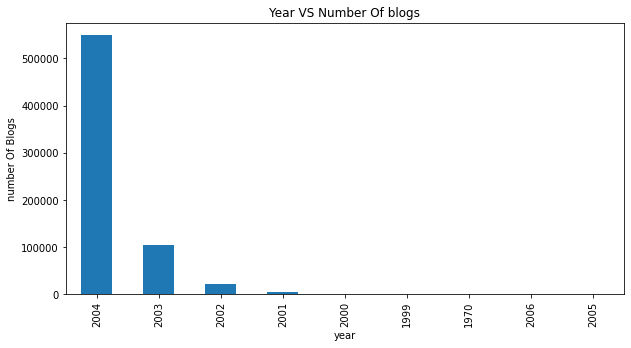

time: 12min 56s (started: 2021-10-31 10:54:17 +00:00)


In [ ]:
blog_df_for_analysis['date'] = pd.to_datetime(blog_df_for_analysis['date'], format='%Y-%m-%d')
blog_df_for_analysis.date.dt.strftime('%Y').value_counts().plot(kind="bar",figsize=(10, 5), title="Year VS Number Of blogs", xlabel = "year", ylabel = "number Of Blogs");

    The above graphs showe number of blogs written by users based on dates.

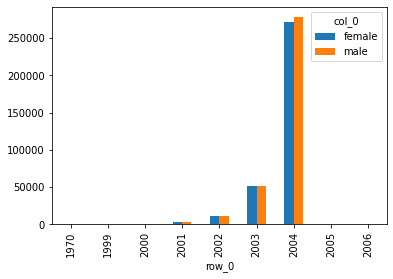

time: 5.26 s (started: 2021-10-31 11:07:14 +00:00)


In [ ]:
pd.crosstab(blog_df_for_analysis.date.dt.strftime('%Y'),blog_df_for_analysis['gender']).plot.bar();

    The above graph shows the number of graphs based on gender with year on X-Axis

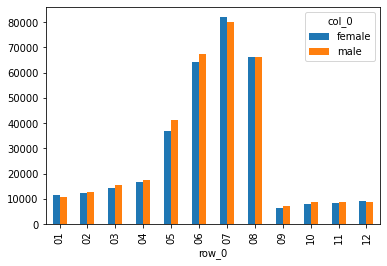

time: 4.05 s (started: 2021-10-31 11:07:19 +00:00)


In [ ]:
pd.crosstab(blog_df_for_analysis.date.dt.strftime('%m'),blog_df_for_analysis['gender']).plot.bar();

        The above graph shows the number of graphs based on gender with month on X-Axis

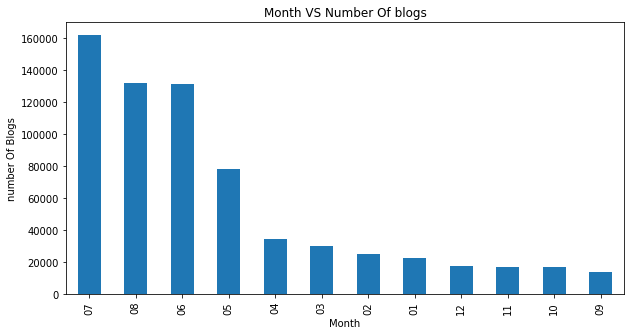

time: 5.1 s (started: 2021-10-31 11:07:23 +00:00)


In [ ]:
blog_df_for_analysis.date.dt.strftime('%m').value_counts().plot(kind="bar",figsize=(10, 5), title="Month VS Number Of blogs", xlabel = "Month", ylabel = "number Of Blogs");

    Plotting graph of month vs number of blogs. It looks like we are having more number of blogs written in the july month.

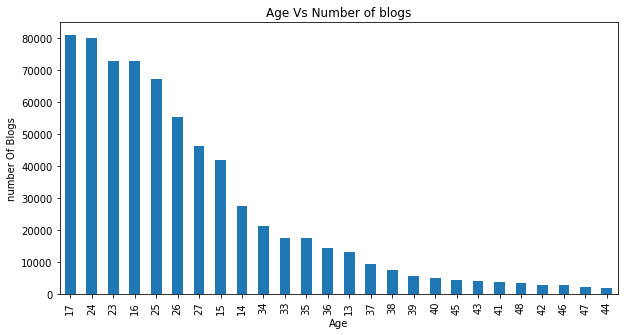

time: 3.3 s (started: 2021-10-31 11:07:28 +00:00)


In [ ]:
blog_df_for_analysis.age.value_counts().plot(kind="bar",figsize=(10, 5), title="Age Vs Number of blogs", xlabel = "Age", ylabel = "number Of Blogs");

    By Above graph we can say that more number of young people are fond of blogging.

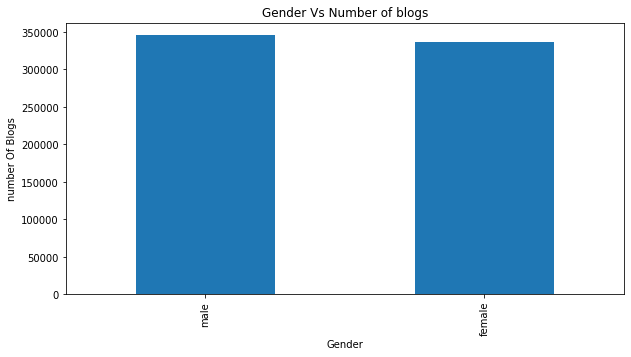

time: 3.11 s (started: 2021-10-31 11:07:31 +00:00)


In [ ]:
blog_df_for_analysis.gender.value_counts().plot(kind="bar",figsize=(10, 5), title="Gender Vs Number of blogs", xlabel = "Gender", ylabel = "number Of Blogs");

    Both genders are having same interest in writing the blogs

In [ ]:
print(" Unique values in sign column :: " , blog_df_for_analysis.sign.unique())
print()
print(" Unique values in topic column :: ", blog_df_for_analysis.topic.unique())
print()
print(" Unique values in gender column :: ", blog_df_for_analysis.gender.unique())

 Unique values in sign column ::  ['Leo' 'Aquarius' 'Aries' 'Capricorn' 'Gemini' 'Cancer' 'Sagittarius'
 'Scorpio' 'Libra' 'Virgo' 'Taurus' 'Pisces']

 Unique values in topic column ::  ['Student' 'InvestmentBanking' 'indUnk' 'Non-Profit' 'Banking' 'Education'
 'Engineering' 'Science' 'Communications-Media' 'BusinessServices'
 'Sports-Recreation' 'Arts' 'Internet' 'Museums-Libraries' 'Accounting'
 'Technology' 'Law' 'Consulting' 'Automotive' 'Religion' 'Fashion'
 'Publishing' 'Marketing' 'LawEnforcement-Security' 'HumanResources'
 'Telecommunications' 'Military' 'Government' 'Transportation'
 'Architecture' 'Advertising' 'Agriculture' 'Biotech' 'RealEstate'
 'Manufacturing' 'Construction' 'Chemicals' 'Maritime' 'Tourism'
 'Environment']

 Unique values in gender column ::  ['male' 'female']
time: 4.45 s (started: 2021-10-31 11:07:34 +00:00)


In [ ]:
blog_df

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ..."
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i..."
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin..."
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as..."


time: 680 ms (started: 2021-10-31 11:07:39 +00:00)


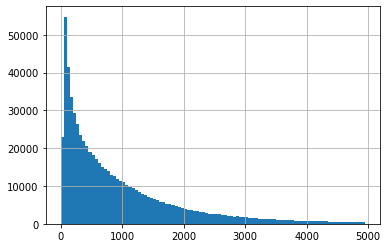

time: 1.31 s (started: 2021-10-31 11:07:40 +00:00)


In [ ]:
lens = blog_df_for_analysis.text.str.len()
lens.hist(bins = np.arange(0,5000,50))

    The above graphs shows the most blogs are having around 250 words. There are very less number of blogs which are having more than 4000 words. If we plot number of words v/s topic column that would give insight into the serious topic on which people have written lenghty blogs.

In [ ]:
print('Number of missing comments in comment text:')
blog_df_for_analysis['text'].isnull().sum()

Number of missing comments in comment text:


0

time: 378 ms (started: 2021-10-31 11:07:41 +00:00)


## Perform data pre-processing on the data:


### Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase

    Next 2 cells has few function implementation which aids for data cleansing.

In [ ]:
wnl = WordNetLemmatizer()

from nltk import sent_tokenize, word_tokenize

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

print((blog_df.text[0]))
print(' '.join(lemmatize_sent(blog_df.text[0])))

           Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.         
info have be find ( +/- 100 page , and 4.5 mb of .pdf file ) now i have to wait untill our team leader have process it and learn html .
time: 3.6 s (started: 2021-10-31 11:07:41 +00:00)


In [ ]:
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
words = set(nltk.corpus.words.words())

class CleanUpData():
  '''CleanUpData has few function to clean up input string
  It has a function 
    1) To remove space
    2) To remove special characters
    3) To remove accented characters    
    '''

  def remove_non_english_words(blog):
    return " ".join(w for w in nltk.wordpunct_tokenize(blog) if w.lower() in words or not w.isalpha())

  def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
  def lemmatize_sent(text):
    # Text input is string, returns lowercased strings.
    return " ".join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text))])

  def worker_wrapperr(arg):
    word, pos = arg
    wnl = WordNetLemmatizer()
    return wnl.lemmatize(word, pos)

  #Below code is only required if we are not using modin. This use pool function.
  def lemmed(text, cores=6):
    # tweak cores as needed
    argg = [(word.lower(), penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text))]
    with Pool(processes=cores) as pool:
        wnl = WordNetLemmatizer()
        result = pool.map(CleanUpData.worker_wrapperr,  argg) #text.split())
    return result

  def remove_special_characters(text, remove_digits=False):
    #Using regex
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

  def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

  def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

  def remove_emojis(text):
    return emoji.demojize(blog_df.text[1].replace(':',''))

  def remove_stop_words(text):
    listOfWords = text.split(' ')
    # print(listOfWords)
    stop_words = set(stopwords.words('english'))
    rtext = ''
    for word in text.split(' '):
      # print(word)
      if(word not in stop_words):
        rtext = rtext + ' ' + word
    return rtext

time: 314 ms (started: 2021-10-31 11:07:45 +00:00)


  Lets check the function which are written to cleanse the text in the dataframe. This would give us some idea on how cleansing work on the text data

In [ ]:
ilocat = 100
print("Original Text :: " , blog_df.text[ilocat])
print("Accented chars removed :: ", CleanUpData.remove_accented_chars(blog_df.text[ilocat]))
print("Upon removing Special chars ::", CleanUpData.remove_special_characters(blog_df.text[ilocat]))
print("Upon removing emojis ::", CleanUpData.remove_emojis(blog_df.text[ilocat]))
print("Upon removing stopwords ::", CleanUpData.remove_stop_words(blog_df.text[ilocat]))
print("Removing non english text :: ", CleanUpData.remove_non_english_words(blog_df.text[ilocat]))
print("lemmatize_sent :: " , CleanUpData.lemmatize_sent(blog_df.text[ilocat]))
print("lemmed : " , CleanUpData.lemmatize_sent(blog_df.text[ilocat]))

Original Text ::                   i can't wait for things to get moving, i want out of here. im lookin forward to uni although it means another 3 years in england. it should be so much fun from my experiences of it so far and my brother's experiences. after uni though it will be another year i guess before i can move, as i'll need to work for 'bout that long to get some money. will be quite lonely i imagine as every1 will have moved on by then. i wana work in a pub, duno why, not any pub, not a big pub, i'd love to work the fox n hound by jill's - it's small n friendly, i think thats what attracks me to bein a barmaid - every1 thinks its somit to look down on but what's so bad bein surrounded by people in a friendly (if smoky :s) atmosphere? mayb im naive... also hav a job lined up with jill i hope :) i love the sound of what she plans to do and she says she'll employ me :) ur pretty much self-employed to be honest so it should happen n im into herbal homeopathic stuff so sounds good 

    Below function bind all the function used for cleaning text data.

In [ ]:
def text_cleaner(inputDataFrame):
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.remove_special_characters)
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.remove_accented_chars)
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.remove_stop_words)
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.remove_non_english_words)
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.lemmatize_sent)
    inputDataFrame['text'] = inputDataFrame.text.apply(CleanUpData.clean_text)
    return inputDataFrame

time: 5.71 ms (started: 2021-10-31 11:07:46 +00:00)


In [ ]:
blog_df['Cleaned_text'] = text_cleaner(blog_df['text'].to_frame())

time: 40min 14s (started: 2021-10-31 11:07:46 +00:00)


  Label Encoding on the individual labels which will be used for tfidf vecorizer.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# df[['gender', 'topic', 'sign']] = df[['gender', 'topic', 'sign']].apply(le.fit_transform)
blog_df['gender_le'] = blog_df[['gender']].apply(le.fit_transform)
blog_df['topic_le'] = blog_df[['topic']].apply(le.fit_transform)
blog_df['sign_le'] = blog_df[['sign']].apply(le.fit_transform)

categories = ['gender_le', 'sign_le' , 'topic_le',  'age']
blog_df

,id,gender,age,topic,sign,date,text,Cleaned_text,gender_le,topic_le,sign_le
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",find 100 45 now wait untill team leader,1,34,5
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these team van mail mail mail,1,34,5
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het van how build from subject how to build...,1,34,5
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,test test,1,34,5
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks i capture i show cool link pop audio vi...,1,20,0
...,...,...,...,...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ...",dear i could write really bitter diatribe dise...,1,34,10
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i...",dear i second yeast infection past two straigh...,1,34,10
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin...",dear your bald good luck,1,34,10
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as...",dear just clarify i leave house why piss floor...,1,34,10


time: 34.7 s (started: 2021-10-31 11:48:01 +00:00)


In [ ]:
#Below piece of code is replaced by using Modin 
# from more_itertools import sliced
# CHUNK_SIZE = 100

# index_slices = sliced(range(len(blog_df)), CHUNK_SIZE)

# listOdDf = []
# for index_slice in index_slices:
#   chunk = blog_df.iloc[index_slice]
#   listOdDf.append(chunk)

# with Pool(processes=6) as pool:
#   result = pool.map(review_cleaner, listOdDf) 

time: 1.9 ms (started: 2021-10-31 11:48:36 +00:00)


    Check few records in dataframe, This manual checking would help to understand the data preprocessing.

In [ ]:
print(blog_df.text[12])
print(blog_df.Cleaned_text[12])

             Last night was pretty fun...mostly because of the company I kept.  I recently met a couple of finance-types here in Yeouido (which isn't too hard to do, as it's referred to as Korea's Wall Street) who spoke pretty good English (which is a rarity here not only in Yeouido but everywhere in Korea).  They had studied outside Korea and deal with international business...but still my brutal Canadian accent made it pretty tough for them to figure out what I was saying sometimes.  There was one time that their accent got in the way, though.  When we went to the restaurant the guy (Junseok, the gal is named Hye-Kyung) asked: 'Do you like deok?'  I wrote it just as I heard it.  I thought he meant dog (they eat that here) so I called his bluff and said, 'Sure, let's go! What kind of dog?' 'Oh no, deok, deok!' 'Ya, dog?' 'No, deok,' he said again. Then I figured out that he meant 'duck' and said, 'Oh, &#50724;&#47532; (oh-ri), duck! Not &#44060; (gay), dog! Why didn't you just speak K

### Target/label merger and transformation

In [ ]:
blog_df['label_four_column'] = blog_df.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)
blog_df['label_three_column'] = blog_df.apply(lambda col : [col['gender'],col['topic'],col['sign']], axis=1)

time: 28.9 s (started: 2021-10-31 11:48:36 +00:00)


### Train and test split

  There will be 2 types of approachs

  Approach #1: Application of algorithm on text VS single label [gender, age, topic, sign] separately. 
              In this approach, there will be 2 types of vecotrization technique tried - TFIDF and count vectorizer.

  Approach #2: Application of algorithm on text VS merged labels.

  Appropriate marking are done for these approaches in this notebook.

  Approach #1: Application of algorithm on text VS single label [gender, age, topic, sign] separately. The code for same are in cells below. At first we shall look into count vectorizer technique.

In [ ]:
from sklearn.model_selection import train_test_split
# split X and y into training and testing sets
blog_topic_train, blog_topic_test, y_topic_train, y_topic_test = train_test_split(blog_df.Cleaned_text, blog_df.topic, random_state=2)

#Traing data
print(blog_topic_train.shape)
print(y_topic_train.shape)

#Test Data
print(blog_topic_test.shape)
print(y_topic_test.shape)

(510963,)
(510963,)
(170321,)
(170321,)
time: 17.9 s (started: 2021-10-31 11:49:05 +00:00)


### Vectorisation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#we can restrict the number of features using below method
# cvect = CountVectorizer(min_df=2, max_df=0.5, max_features=300)

#CountVectorizer (with the default parameters)
cvect = CountVectorizer()

time: 2.83 ms (started: 2021-10-31 11:49:23 +00:00)


In [ ]:
#CountVectorize the blog data
cvect.fit(blog_topic_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

time: 49.4 s (started: 2021-10-31 11:49:23 +00:00)


In [ ]:
#Check the vocablury size
print(len(cvect.vocabulary_))

160634
time: 1.19 ms (started: 2021-10-31 11:50:13 +00:00)


In [ ]:
#What is there in the vocabulary
cvect.vocabulary_

{'thats': 147555,
 'sure': 145340,
 'come': 79613,
 'place': 127347,
 'read': 133166,
 'let': 112515,
 'introduce': 108122,
 'first': 91849,
 'year': 159771,
 '2000': 23215,
 'computer': 79973,
 'science': 137813,
 'graduate': 95726,
 'fast': 90967,
 'institute': 107649,
 'topper': 149294,
 'share': 139424,
 '378': 37269,
 'two': 150784,
 'batch': 72096,
 'after': 66994,
 'graduation': 95729,
 'one': 122851,
 'prestigious': 130460,
 'clear': 78832,
 'exam': 89662,
 '91': 61285,
 'select': 138543,
 'application': 69239,
 'server': 139003,
 'commerce': 79716,
 'suite': 144916,
 'training': 149640,
 'conduct': 80132,
 'train': 149631,
 'back': 71349,
 'company': 79809,
 'day': 83236,
 'later': 111940,
 '2001': 23356,
 'hire': 98468,
 'write': 158579,
 'transaction': 149683,
 'engine': 88611,
 'specialize': 142432,
 'banking': 71806,
 'domain': 86057,
 'upon': 154092,
 'completion': 79891,
 'project': 130917,
 'give': 94970,
 '50': 44856,
 'increment': 106812,
 'pay': 125593,
 'well': 1570

time: 36.6 ms (started: 2021-10-31 11:50:13 +00:00)


In [ ]:
#Convert Training SMS messages into Count Vectors
X_train_ct = cvect.transform(blog_topic_train)

time: 48.8 s (started: 2021-10-31 11:50:13 +00:00)


In [ ]:
#Size of Document Term Matrix
X_train_ct.shape

(510963, 160634)

time: 7.35 ms (started: 2021-10-31 11:51:02 +00:00)


In [ ]:
X_test_ct = cvect.transform(blog_topic_test)

time: 16.6 s (started: 2021-10-31 11:51:02 +00:00)


In [ ]:
blog_df.iloc[19].text

"             So I've been in Vancouver a few days now...in Coquitlam, actually.  It's really an interesting place; I used to think it was full of Chinese people (not that there's anything wrong with that, but Vancouver's #1 mother tongue is Mandarin/Cantonese, so you'd assume there'd be tons here).  Our area is up on a hill in a little bit of paradise, actually.  It has started to remind me of Newport in that show  urlLink The O.C.  (O.C. means Orange County).  Well, it isn't full of million dollar homes (but there are a few) but the topography is similar (hills, lots of parks, but no beach) and it's really, really white here.  I think the only Koreans I've seen have been family and Ensign Harry Kim on Star Trek: Voyager (ya, still have jetlag...watching anything that hits the screen here).  On that note, I think I'm having T.V. overload.  Well, with the kids I don't get to see too much of it, but when I do I'm boggled by the 60+ stations (and that's not even satellite!) and all, save

time: 685 ms (started: 2021-10-31 11:51:18 +00:00)


In [ ]:
#What's there in sparse matrix
print(X_train_ct[19])

  (0, 16662)	1
  (0, 30549)	1
  (0, 40179)	1
  (0, 67142)	1
  (0, 67876)	1
  (0, 68397)	1
  (0, 68711)	1
  (0, 71349)	1
  (0, 72503)	1
  (0, 74620)	1
  (0, 75631)	2
  (0, 76649)	2
  (0, 76747)	1
  (0, 79613)	1
  (0, 82824)	1
  (0, 83236)	1
  (0, 84249)	1
  (0, 84840)	1
  (0, 85857)	1
  (0, 85960)	1
  (0, 86128)	2
  (0, 86640)	1
  (0, 87927)	1
  (0, 89530)	1
  (0, 91749)	1
  :	:
  (0, 122727)	1
  (0, 123338)	2
  (0, 125988)	2
  (0, 127407)	1
  (0, 133237)	1
  (0, 135240)	1
  (0, 137454)	4
  (0, 144432)	1
  (0, 145367)	2
  (0, 146587)	1
  (0, 147737)	1
  (0, 147928)	1
  (0, 147939)	1
  (0, 147981)	1
  (0, 148159)	1
  (0, 148940)	1
  (0, 149103)	1
  (0, 149152)	1
  (0, 149849)	1
  (0, 151018)	1
  (0, 156435)	2
  (0, 156791)	1
  (0, 157050)	1
  (0, 159771)	1
  (0, 159949)	1
time: 9.89 ms (started: 2021-10-31 11:51:19 +00:00)


In [ ]:
X_test_ct.shape

(170321, 160634)

time: 7.01 ms (started: 2021-10-31 11:51:19 +00:00)


  Design, train, tune and test the best text classifier for Approach #1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

time: 60.3 ms (started: 2021-10-31 13:03:33 +00:00)


In [ ]:
# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
knn.fit(X_train_ct, y_topic_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

time: 320 ms (started: 2021-10-31 13:03:33 +00:00)


In [ ]:
from sklearn import metrics
### Calculate accuracy on Training Dataset
print("KNN Train Accuracy", metrics.accuracy_score(y_topic_train, knn.predict(X_train_ct)))
#Calculate accuracy on Test Dataset
prediction_knn = knn.predict(X_test_ct)
print("KNN Test Accuracy", metrics.accuracy_score(y_topic_test, prediction_knn))

KNN Train Accuracy 0.4512
KNN Test Accuracy 0.2472
time: 18.2 s (started: 2021-10-31 13:03:34 +00:00)


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

target_names = blog_df['topic'].unique()
cm = classification_report(y_topic_test, prediction_knn, target_names=target_names)
print(cm)

                         precision    recall  f1-score   support

                Student       0.00      0.00      0.00        11
      InvestmentBanking       0.15      0.18      0.17        11
                 indUnk       0.02      0.29      0.05        14
             Non-Profit       0.00      0.00      0.00        17
                Banking       0.05      0.02      0.03        89
              Education       0.25      0.04      0.07        25
            Engineering       0.00      0.00      0.00        18
                Science       0.00      0.00      0.00        11
   Communications-Media       0.12      0.07      0.09        41
       BusinessServices       0.07      0.40      0.12       108
      Sports-Recreation       0.00      0.00      0.00         8
                   Arts       0.00      0.00      0.00        34
               Internet       0.27      0.07      0.11       212
      Museums-Libraries       0.04      0.01      0.02        86
             Accounting 

  As we can see in above result, the accuracy which signifies ratio of correctly predicted observation to the total observations is at good score for single label prediction. Here we have considered topic label which is having many classes and when compared this label with text column there are more corellation between the words in the text column and the topic label and this could be one of the reason for getting good accuracy score. Precision is the ratio of correctly predicted positive observations to the total predicted positive observations, When we observe the same for Law topic it is showing high score and we can relate to this since there will be unique words which are related to law and hence the topic will be marked approriately. For this use case precision is important and should be observed closely. 

  Lets run the SVC on same data and check the scores

In [ ]:
from sklearn.svm import SVC
####Train an SVM with default parameters
svc = SVC()
svc.fit(X_train_ct, y_topic_train)
### Calculate accuracy on Training Dataset
print(" Accuracy on Training Dataset " , metrics.accuracy_score(y_topic_train, svc.predict(X_train_ct)))
####Calculate accuracy on Test Dataset
prediction = svc.predict(X_test_ct)
print(" Accuracy on Test Dataset ", metrics.accuracy_score(y_topic_test, prediction))

 Accuracy on Training Dataset  0.5366
 Accuracy on Test Dataset  0.41
time: 7min 51s (started: 2021-10-31 13:03:53 +00:00)


In [ ]:
print(classification_report(y_topic_test, prediction, target_names=target_names))

                         precision    recall  f1-score   support

                Student       0.00      0.00      0.00        11
      InvestmentBanking       0.00      0.00      0.00        11
                 indUnk       0.00      0.00      0.00        14
             Non-Profit       0.00      0.00      0.00        17
                Banking       0.00      0.00      0.00        89
              Education       1.00      0.12      0.21        25
            Engineering       0.00      0.00      0.00        18
                Science       0.00      0.00      0.00        11
   Communications-Media       1.00      0.02      0.05        41
       BusinessServices       0.00      0.00      0.00       108
      Sports-Recreation       0.00      0.00      0.00         8
                   Arts       0.00      0.00      0.00        34
               Internet       1.00      0.02      0.04       212
      Museums-Libraries       0.00      0.00      0.00        86
             Accounting 

  The score given by accuracy is better than knn and we can observe good results in the precision for many labels like Communications-Media, Law. Using SVC for single label classification seems provide more precise result.

  TF-IDF vectorization technique will be implemented in below cells. Again, we are applying alogorithm on text against single label. This is approach #1 but with TFIDF

In [ ]:
train, test = train_test_split(blog_df, random_state=2, test_size=0.33, shuffle=True)

time: 14.6 s (started: 2021-10-31 11:37:17 +00:00)


In [ ]:
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(456460,)
(224824,)
time: 37.7 ms (started: 2021-10-31 11:37:32 +00:00)


In [ ]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

time: 16.7 ms (started: 2021-10-31 11:37:32 +00:00)


In [ ]:
def trim(s):
    if(s != 'age'):
      clm_name = s[ : -3]
    else:
      clm_name = 'age'
    return  clm_name 

time: 1.93 ms (started: 2021-10-31 11:37:32 +00:00)


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None), n_jobs = -1)),
            ])
    
categories = ['gender_le', 'sign_le' , 'topic_le',  'age']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction_C_NB_OVR = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction_C_NB_OVR)))
    target_names = [str(names) for names in blog_df[trim(category)].unique()] 
    cm = classification_report(test[category], prediction_C_NB_OVR, target_names=target_names)
    print(cm)
    print("\n\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
... Processing gender_le
Test accuracy is 0.6884273920933708
              precision    recall  f1-score   support

        male       0.66      0.75      0.70    110795
      female       0.72      0.63      0.67    114029

    accuracy                           0.69    224824
   macro avg       0.69      0.69      0.69    224824
weighted avg       0.69      0.69      0.69    224824




... Processing sign_le
Test accuracy is 0.23025566665480554
              precision    recall  f1-score   support

         Leo       0.72      0.08      0.14     16428
    Aquarius       0.22      0.43      0.29     21441
       Aries       0.15      0.62      0.24     21571
   Capricorn       0.68      0.04      0.07     16257
      Gemini       0.65      0.07      0.12     17121
      Cancer       0.57      0.08      0.15     17684
 Sagittarius       0.23      0.33      0.27     206

                         precision    recall  f1-score   support

                Student       0.00      0.00      0.00      1252
      InvestmentBanking       0.91      0.01      0.01      1547
                 indUnk       0.00      0.00      0.00       403
             Non-Profit       0.00      0.00      0.00       555
                Banking       0.69      0.00      0.00     10658
              Education       0.00      0.00      0.00       419
            Engineering       0.00      0.00      0.00      1366
                Science       0.00      0.00      0.00       737
   Communications-Media       0.00      0.00      0.00      1481
       BusinessServices       0.00      0.00      0.00      1348
      Sports-Recreation       0.97      0.00      0.01      6667
                   Arts       0.00      0.00      0.00       373
               Internet       0.00      0.00      0.00      1962
      Museums-Libraries       0.65      0.01      0.01      9853
             Accounting 

              precision    recall  f1-score   support

          15       0.92      0.01      0.01      4341
          33       0.90      0.04      0.08      8969
          14       0.84      0.03      0.06     13931
          25       0.49      0.24      0.32     24046
          17       0.25      0.73      0.37     26683
          23       0.41      0.16      0.23     24171
          37       0.16      0.73      0.27     26164
          26       0.49      0.09      0.16     22199
          24       0.73      0.06      0.11     18195
          27       0.70      0.03      0.06     15084
          45       1.00      0.00      0.00      5855
          34       0.99      0.03      0.07      7161
          41       0.95      0.02      0.03      5801
          44       1.00      0.00      0.01      4712
          16       1.00      0.01      0.02      3076
          39       1.00      0.01      0.02      2466
          35       0.00      0.00      0.00      1840
          36       1.00    

    When we look at classification report for individual labels we observe that the model has some room for improvement. Although it is having good precision score compared to recall, but the score are not in acceptable range. A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
            ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction_C_SVC_OVR = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction_C_SVC_OVR)))
    target_names = [str(names) for names in blog_df[trim(category)].unique()] 
    cm = classification_report(test[category], prediction_C_SVC_OVR, target_names=target_names)
    print(cm)
    print("\n\n")

... Processing gender_le
Test accuracy is 0.7162180194285308
              precision    recall  f1-score   support

        male       0.72      0.70      0.71    110795
      female       0.72      0.73      0.72    114029

    accuracy                           0.72    224824
   macro avg       0.72      0.72      0.72    224824
weighted avg       0.72      0.72      0.72    224824




... Processing sign_le
Test accuracy is 0.28734031953883926
              precision    recall  f1-score   support

         Leo       0.31      0.28      0.29     16428
    Aquarius       0.29      0.35      0.31     21441
       Aries       0.30      0.31      0.31     21571
   Capricorn       0.27      0.24      0.26     16257
      Gemini       0.28      0.27      0.28     17121
      Cancer       0.28      0.27      0.28     17684
 Sagittarius       0.27      0.29      0.28     20692
     Scorpio       0.31      0.29      0.30     17947
       Libra       0.30      0.25      0.27     16452
       V

    Application of linear SVC on the data has improved when compared with MultinomialNB classifier. But lets check with LogisticRegression classifier before concluding on the final good model.

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction_C_LR_OVR = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction_C_LR_OVR)))
    target_names = [str(names) for names in blog_df[trim(category)].unique()] 
    cm = classification_report(test[category], prediction_C_LR_OVR, target_names=target_names)
    print(cm)
    print("\n\n")

... Processing gender_le
Test accuracy is 0.7129043162651674
              precision    recall  f1-score   support

        male       0.72      0.69      0.70    110795
      female       0.71      0.73      0.72    114029

    accuracy                           0.71    224824
   macro avg       0.71      0.71      0.71    224824
weighted avg       0.71      0.71      0.71    224824




... Processing sign_le
Test accuracy is 0.2573390741202007
              precision    recall  f1-score   support

         Leo       0.30      0.22      0.26     16428
    Aquarius       0.25      0.35      0.29     21441
       Aries       0.26      0.31      0.28     21571
   Capricorn       0.27      0.19      0.22     16257
      Gemini       0.26      0.22      0.23     17121
      Cancer       0.25      0.22      0.24     17684
 Sagittarius       0.24      0.28      0.25     20692
     Scorpio       0.30      0.25      0.27     17947
       Libra       0.29      0.20      0.24     16452
       Vi

                         precision    recall  f1-score   support

                Student       0.47      0.06      0.11      1252
      InvestmentBanking       0.90      0.02      0.05      1547
                 indUnk       1.00      0.00      0.01       403
             Non-Profit       0.50      0.00      0.01       555
                Banking       0.66      0.09      0.16     10658
              Education       0.00      0.00      0.00       419
            Engineering       0.84      0.03      0.05      1366
                Science       0.84      0.04      0.08       737
   Communications-Media       0.91      0.08      0.14      1481
       BusinessServices       0.55      0.00      0.01      1348
      Sports-Recreation       0.65      0.04      0.08      6667
                   Arts       1.00      0.03      0.06       373
               Internet       0.68      0.01      0.01      1962
      Museums-Libraries       0.66      0.09      0.15      9853
             Accounting 

    The above cell contains LogisticRegression classifier which is run on individual labels. For gender label, it is having 71% macro average and 71% recall. This single label classification and hence we can consider the macro avg. An ideal system with high precision and high recall will return many results, with all results labeled correctly. The sign label is having many classes and LogisticRegression has not performed well in this classification. Both recall and precision are low. The topic label is having 69% precision macro average and when we look into individual classes it has performed pretty much good, but there is lot of room for improvement. When we look into each class of the age label, we can observe that the model performance is good for this label.
    When we apply classifier on individual labels, we observe that it is having good individual accuracy and good precision score.

  Approach #2: In this approach a multiclass label is used prediction. The same cleansed text is used as X variable but Y variable is merged lables in the data set. Here we are merging 4 column - Gender, age, topic and sign. Upon this we are going to apply algorithm.

In [ ]:
#check the variable creation before application of algorithm
blog_df

,id,gender,age,topic,sign,date,text,Cleaned_text,gender_le,topic_le,sign_le,label_four_column,label_three_column
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",find 100 45 now wait untill team leader,1,34,5,"[male, 15, Student, Leo]","[male, Student, Leo]"
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these team van mail mail mail,1,34,5,"[male, 15, Student, Leo]","[male, Student, Leo]"
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het van how build from subject how to build...,1,34,5,"[male, 15, Student, Leo]","[male, Student, Leo]"
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,test test,1,34,5,"[male, 15, Student, Leo]","[male, Student, Leo]"
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks i capture i show cool link pop audio vi...,1,20,0,"[male, 33, InvestmentBanking, Aquarius]","[male, InvestmentBanking, Aquarius]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ...",dear i could write really bitter diatribe dise...,1,34,10,"[male, 23, Student, Taurus]","[male, Student, Taurus]"
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i...",dear i second yeast infection past two straigh...,1,34,10,"[male, 23, Student, Taurus]","[male, Student, Taurus]"
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin...",dear your bald good luck,1,34,10,"[male, 23, Student, Taurus]","[male, Student, Taurus]"
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as...",dear just clarify i leave house why piss floor...,1,34,10,"[male, 23, Student, Taurus]","[male, Student, Taurus]"


time: 895 ms (started: 2021-10-31 11:32:17 +00:00)


In [ ]:
X= blog_df.Cleaned_text
y = blog_df.label_four_column

time: 7.75 ms (started: 2021-10-31 11:52:00 +00:00)


In [ ]:
#check content of variable X
X

0                   find 100 45 now wait untill team leader
1                             these team van mail mail mail
2         in het van how build from subject how to build...
3                                                 test test
4         thanks i capture i show cool link pop audio vi...
                                ...                        
681279    dear i could write really bitter diatribe dise...
681280    dear i second yeast infection past two straigh...
681281                             dear your bald good luck
681282    dear just clarify i leave house why piss floor...
681283    hey you might already know my weird al i get t...
Name: Cleaned_text, Length: 681284, dtype: object

time: 103 ms (started: 2021-10-31 11:52:00 +00:00)


In [ ]:
#check content of variable y (label)
y

0                        [male, 15, Student, Leo]
1                        [male, 15, Student, Leo]
2                        [male, 15, Student, Leo]
3                        [male, 15, Student, Leo]
4         [male, 33, InvestmentBanking, Aquarius]
                           ...                   
681279                [male, 23, Student, Taurus]
681280                [male, 23, Student, Taurus]
681281                [male, 23, Student, Taurus]
681282                [male, 23, Student, Taurus]
681283                [male, 23, Student, Taurus]
Name: label_four_column, Length: 681284, dtype: object

time: 87.5 ms (started: 2021-10-31 11:52:02 +00:00)


In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2,test_size = 0.2)

time: 17 s (started: 2021-10-31 11:52:04 +00:00)


In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(545027,)
(545027,)
(136257,)
(136257,)
time: 7.44 ms (started: 2021-10-31 11:52:21 +00:00)


In [ ]:
label_counts=dict()

for labels in blog_df.label_four_column.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

time: 3.22 s (started: 2021-10-31 11:52:21 +00:00)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

time: 1.81 ms (started: 2021-10-31 11:52:24 +00:00)


In [ ]:
y_train = binarizer.fit_transform(y_train)

time: 3.27 s (started: 2021-10-31 11:52:24 +00:00)


In [ ]:
y_test = binarizer.transform(y_test)

time: 763 ms (started: 2021-10-31 11:52:27 +00:00)


In [ ]:
X_train

590624                                               canada
197519    i dont see much scan burn future sorry unless ...
147301    ko na papa ko gusto ko na ko yesterday sa sop ...
114077                                 u clear grave pretty
357895    so sitting work morning go normal get work rou...
                                ...                        
84434     wh0ot 620 morning sister give birth 7lb 13oz b...
437782                                            and whats
620104    hey today long say least i get super early i d...
203245    a week i find laughter smile fatigue i feel go...
100879    rio 12 04 9 farewell dinner larry restaurant i...
Name: Cleaned_text, Length: 545027, dtype: object

time: 110 ms (started: 2021-10-31 11:54:43 +00:00)


In [ ]:
#checking the label train variable.
y_train

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

time: 6.41 ms (started: 2021-10-31 11:54:47 +00:00)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(545027,)
(545027, 80)
(136257,)
(136257, 80)
time: 4.3 ms (started: 2021-10-31 11:54:48 +00:00)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

time: 8.94 ms (started: 2021-10-31 11:54:49 +00:00)


In [ ]:
#Initializing Vectorization of Climate posts
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorised_train_documents = vectorizer.fit_transform(X_train)
vectorised_test_documents = vectorizer.transform(X_test)
# print(vectorised_train_documents)
# print(vectorised_test_documents)

time: 1min 2s (started: 2021-10-31 12:05:42 +00:00)


In [ ]:
print(vectorised_train_documents)

  (0, 79590)	1.0
  (1, 79910)	0.17057181818597883
  (1, 118530)	0.12588159449605357
  (1, 122399)	0.3234415935491709
  (1, 133363)	0.1448299584993193
  (1, 162926)	0.23118456027139778
  (1, 96964)	0.15932775889761905
  (1, 99475)	0.4190672832439514
  (1, 154314)	0.3792520880419818
  (1, 152666)	0.1247568853675155
  (1, 125291)	0.2823716840269498
  (1, 138471)	0.10278958687197529
  (1, 72887)	0.17302220036287563
  (1, 158545)	0.2178922214364242
  (1, 147558)	0.17958228080149802
  (1, 97416)	0.2030658161228118
  (1, 78617)	0.22485625892438985
  (1, 142927)	0.30197266721367716
  (1, 123490)	0.11148898231330266
  (1, 143813)	0.10294103116817388
  (1, 89585)	0.09823583393579922
  (2, 114133)	0.01519869835409899
  (2, 156430)	0.01914207129798274
  (2, 98761)	0.022588095622850957
  (2, 103077)	0.025983183368471875
  :	:
  (545026, 84598)	0.06013216562094178
  (545026, 131303)	0.04746643878376817
  (545026, 100253)	0.04824630396960745
  (545026, 115420)	0.11400508870882224
  (545026, 102020)	0

    Lets check first 50 important words in the given dataset.

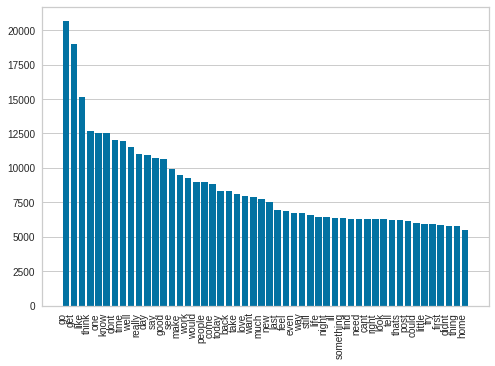

time: 1.36 s (started: 2021-10-31 12:06:45 +00:00)


In [ ]:
from yellowbrick.text import FreqDistVisualizer
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vectorised_train_documents)
visualizer;

    For evaluation of the model performance, we need to shall add the score to dictionary and try to display it at once. Here we are creating different score for checking models performance but we shall create the classification report at last.

In [ ]:
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    ModelsPerformance[modelName] = micro_f1

time: 3.4 ms (started: 2021-10-31 12:06:46 +00:00)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC

time: 33.2 ms (started: 2021-10-31 12:06:46 +00:00)


In [ ]:
#Model: Multinominal Naive Bayes
nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, y_train)
nbPreds = nbClassifier.predict(vectorised_test_documents)
metricsReport(nbClassifier, y_test, nbPreds)

time: 33.5 s (started: 2021-10-31 12:06:46 +00:00)


In [ ]:
ModelsPerformance

{OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                             fit_prior=True),
                     n_jobs=None): 0.335220166942966}

time: 7.59 ms (started: 2021-10-31 12:07:20 +00:00)


In [ ]:
#Model: Linear Support Vector Machine
svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents, y_train)
svmPreds = svmClassifier.predict(vectorised_test_documents)
metricsReport(svmClassifier, y_test, svmPreds)

time: 5min 19s (started: 2021-10-31 12:07:20 +00:00)


In [ ]:
ModelsPerformance

{OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                         fit_intercept=True, intercept_scaling=1,
                                         loss='squared_hinge', max_iter=1000,
                                         multi_class='ovr', penalty='l2',
                                         random_state=None, tol=0.0001,
                                         verbose=0),
                     n_jobs=-1): 0.1639066827968718,
 OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                             fit_prior=True),
                     n_jobs=None): 0.335220166942966}

time: 9.97 ms (started: 2021-10-31 12:12:39 +00:00)


In [ ]:
from sklearn.metrics import classification_report
cmNB = classification_report(y_test, nbPreds)
print(cmNB)
print("\n\n")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

    In above cell, MultinomialNB classification report is shown and the model's predictions micro avergae precision is around 65% which has lot of room for improvement. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. Here one thing we can observe is that the macro avgs are having low score which means the claissifer is able to classify individual labels and collectively it is not having good score.

In [ ]:
cmSVM = classification_report(y_test, svmPreds)
print(cmSVM)
print("\n\n")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

**Observations**: 

    In above cell, SVM classification reprot is shown and the model's predictions are goos in terms of precision, all samples classified as the positive class are truly positive. Micro-averaging will put more emphasis on the common classes in the data set. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. 
    
    In a multi-class classification setup, micro-average is are observed  more than macro averages. If we take precision for individual class the score is in acceptable range. The areas of improvement would be to use some other vectorizer or to use only three labels and exclude the age label from the multilabel. Here we are observing a system with high precision but low recall , returning very few results, but most of its predicted labels are correct when compared to the training labels. Since this  use case is a digital conntent, we can look at precision and evaluate the model.

In [ ]:
for i in [1016,1078,1361,1466,1659,1704,1744]:
  print(" model prediction :", (binarizer.inverse_transform(svmPreds)[i]))
  print(" model true label : ", (binarizer.inverse_transform(y_test)[i]))
  print()

 model prediction : ('Taurus', 'female', 'indUnk')
 model true label :  ('Taurus', 'female', 'indUnk')

 model prediction : ('Student', 'Virgo', 'female')
 model true label :  ('Student', 'Virgo', 'female')

 model prediction : ('Cancer', 'female', 'indUnk')
 model true label :  ('Cancer', 'female', 'indUnk')

 model prediction : ('Aries', 'female', 'indUnk')
 model true label :  ('Aries', 'female', 'indUnk')

 model prediction : ('Cancer', 'female', 'indUnk')
 model true label :  ('Cancer', 'female', 'indUnk')

 model prediction : ('Government', 'Taurus', 'male')
 model true label :  ('Government', 'Taurus', 'male')

 model prediction : ('Leo', 'female', 'indUnk')
 model true label :  ('Leo', 'female', 'indUnk')

time: 10.3 s (started: 2021-10-31 12:57:08 +00:00)


**Observation**:
    
    As we can observe from above, there are many instances which are predicted by the model correctly. One few examples are shown above as mentioned in the task list. In this notebook, we have tried and test several models and with different data preprocessing methods. While building model and reading data, modin is used for prepration of dataframe instead of pandas. Modin run on the dask framework and it helps us to process the data in parallel. Modin uses Ray or Dask to provide an effortless way to speed up your pandas notebooks, scripts, and libraries. In this notebook, we have produced classification report which shows model performance. A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.
    
    At first we tried with single label with count vectorizers method for data preprocessing. But Count vectorizer is unable to find the most important and less important word for analysis. As the name says, it just count the word occurance, although it works for few cases it has disadvantage as mentioned above.
    
    We tried with another vectorizer method - TF-IDF. TF-IDF enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document. This has improved model performance a bit and here we tried to classify for only one label at a time. The accruacy and precision for the model were calculated for each label [topic, age, gender, sign] individually.  Precision is one indicator of a machine learning model's performance – the quality of a positive prediction made by the model.  The precision for all the labels are in acceptable range, although accuracy has room for improvement. This is not the main model, as mentioned in the task list we need to merge the labels and then use multiclass classification to predict the labels.
    
    Finally, in this notebook, a multiclass classification algorithm is applied with logistic regression and SVM. Here SVM is having good score when compare with the  logistic regression. SVM is having 83%  micro avg precision and support is 408771 which is quite a good number. Support is the number of actual occurrences of the class in the specified dataset. The  macro avg is aroung 51% and weighted avg is 84%. Macro avg takes the average of the precision and recall of the system on different sets. Macro-average method can be used when you want to know how the system performs overall across the sets of data. Weighted-averaged, in here each classes's contribution to the average is weighted by its size. We can conclude that SVM is best classifier by far with all the observation stated above.



## Part 2 - Chatbot project for customer support

**DOMAIN:**
Customer support

**CONTEXT:** 

Great Learning has a an academic support department which receives numerous support requests every day throughout the 
year. Teams are spread across geographies and try to provide support round the year. Sometimes there are circumstances where due to  heavy workload certain request resolutions are delayed, impacting company’s business. Some of the requests are very generic where a  proper resolution procedure delivered to the user can solve the problem. Company is looking forward to design an automation which can  interact with the user, understand the problem and display the resolution procedure [ if found as a generic request ] or redirect the request  to an actual human support executive if the request is complex or not in it’s database.

**DATA DESCRIPTION:**

A sample corpus is attached for your reference. Please enhance/add more data to the corpus using your linguistics 
skills.

**PROJECT OBJECTIVE:**

Design a python based interactive semi - rule based chatbot which can do the following: 
    
    1. Start chat session with greetings and ask what the user is looking for.
    2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus. 
    3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.

**EVALUATION:**

GL evaluator will use linguistics to twist and turn sentences to ask questions on the topics described in DATA DESCRIPTION 
and check if the bot is giving relevant replies.

**Hint:** There are a lot of techniques using which one can clean and prepare the data which can be used to train a ML/DL classifier. Hence, it might require you to experiment, 
research, self learn and implement the above classifier. There might be many iterations between hand building the corpus and designing the best fit text classifier. As the quality 
and quantity of corpus increases the model’s performance i.e. ability to answer right questions also increases. 
Reference: https://www.mygreatlearning.com/blog/basics-of-building-an-artificial-intelligence-chatbot/

###### Importing required libraries

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.chat.util import Chat, reflections

###### reading from JSON file

In [2]:
# import pandas as pd
cb_df = pd.read_json('./GL_Bot.json')
cb_df.head(100)

,intents
0,"{'tag': 'Intro', 'patterns': ['hi', 'how are y..."
1,"{'tag': 'Exit', 'patterns': ['thank you', 'tha..."
2,"{'tag': 'Olympus', 'patterns': ['olympus', 'ex..."
3,"{'tag': 'SL', 'patterns': ['i am not able to u..."
4,"{'tag': 'NN', 'patterns': ['what is deep learn..."
5,"{'tag': 'Bot', 'patterns': ['what is your name..."
6,"{'tag': 'Profane', 'patterns': ['what the hell..."
7,"{'tag': 'Ticket', 'patterns': ['my problem is ..."


    There are only 8 records, Here we need to map the intent of the users with responses. It is best to read the data in plain JSON format and then split the data based on tags in the JSON file.
    For simple rule based chatbot we can utilize the  nltk.chat.util   utility to easy up process of building the chatbot. This needs data in certain format which we can plan to prepare.

In [3]:
dic_cb = cb_df.to_dict()

In [4]:
def get_recursively(search_dict, field):
    """
    Takes a dict with nested lists and dicts,
    and searches all dicts for a key of the field
    provided.
    """
    fields_found = []

    for key, value in search_dict.items():

        if key == field:
            fields_found.append(value)

        elif isinstance(value, dict):
            results = get_recursively(value, field)
            for result in results:
                fields_found.append(result)

        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    more_results = get_recursively(item, field)
                    for another_result in more_results:
                        fields_found.append(another_result)

    return tuple(fields_found)


In [5]:
list_of_patterns = get_recursively(dic_cb,"patterns")
list_of_responses = get_recursively(dic_cb,"responses")

chatBot_list=[]
for i in range(0,len(list_of_patterns)):
    listToStr_prefix='r"'
    listToStr=''
    for j in list_of_patterns[i]:
        listToStr = ''.join([str(elem) for elem in j])
        listToStr_prefix =   listToStr_prefix + "|" + listToStr
    listToStr_prefix = listToStr_prefix  + '"'
    list_temp = [listToStr_prefix,list_of_responses[i]]
    chatBot_list.append(list_temp)

In [6]:
def chat():
    print("Hi! I am a chatbot assistant from great learning")
    chat = Chat(chatBot_list, reflections)
    chat.converse()
#initiate the conversation
if __name__ == "__main__":
    chat()

Hi! I am a chatbot assistant from great learning
>hi
Hello! how can i help you ?
>How are you
Hello! how can i help you ?
>what is your name
I am your virtual learning assistant
>hours of working
None
>neural network
None
>artificial intelligence
Link: Neural Nets wiki
>softmax
Link: Neural Nets wiki
>ada boosting
Link: Machine Learning wiki 
>supervised learning
Link: Machine Learning wiki 
>no link visible on olympus
Link: Olympus wiki
>have a Good day
I hope I was able to assist you, Good Bye
>not helping
None
>my problem is not solved
Tarnsferring the request to your PM
>you are stupid
Hello! how can i help you ?
>you are a joke
Hello! how can i help you ?
>quit
None


    As we can observe this is a basic set up and needs a lot of improvement. This chat bot matches exact pattern in the intent and throws responses. There is no generalization involved in these chatbot and needs machine learning to be applied to improve performance. We can apply a simple neural network and check if the chatbot is giving  appropriate response after generalization.

    lets create content using json file, we shall divide the data as X and Y variable for training purpose. Here we will have use the intent as X variable and Y as tags. From tags we will reterive the response. 

In [7]:
import json

with open('./GL_Bot.json') as f:
    data = json.load(f)

In [8]:
Word_list=[]
Lable_list=[]

doc_Xtrain = []
doc_Ytrain = []

for intent in data['intents']:
    for patterns in intent['patterns']:
        word_temp = nltk.word_tokenize(patterns)
        Word_list.extend(word_temp)
        doc_Xtrain.append(word_temp)
        doc_Ytrain.append(intent['tag'])
        
    if intent['tag'] not in Lable_list:
        Lable_list.append(intent['tag'])

In [9]:
ps = nltk.porter.PorterStemmer()
# W = [ps.stem(w.lower()) for w in Word_list if w != "?"]
Word_list = [w.lower() for w in Word_list if w != "?"]
Word_list = sorted(list(set(Word_list)))
Lable_list = sorted(Lable_list)

In [10]:
len(Lable_list)

8

    Creating Bag Of Words for the input words

In [11]:
Train = []
Target = []

out_array_zero = [0 for _ in range(len(Lable_list))]

for x,doc in enumerate(doc_Xtrain):
    bag=[]
    w_temp = [w.lower() for w in doc]
#     w_temp = [ps.stem(w.lower()) for w in doc]
    
    for w in Word_list:
        if w in w_temp:
            bag.append(1)
        else:
            bag.append(0)
            
    output_row = out_array_zero[:]
    output_row[Lable_list.index(doc_Ytrain[x])] = 1
    
    Train.append(bag)
    Target.append(output_row)

In [12]:
bow_xtrain = np.asarray(Train)
bow_ytrain = np.asarray(Target)
print(bow_xtrain.shape)
print(bow_ytrain.shape)

(128, 160)
(128, 8)


In [13]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
            ])

SVC_pipeline.fit(bow_xtrain, bow_ytrain)
# compute the testing accuracy
prediction = SVC_pipeline.predict(bow_xtrain)
print('Test accuracy is {}'.format(accuracy_score(bow_ytrain, prediction)))

Test accuracy is 1.0


    This model looks like it is a overfitting one and hence we have to try with Neural network model.

In [14]:
import tensorflow as tf
#Start building a Keras Sequential Model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

#Add hidden layers
model.add(tf.keras.layers.Dense(160, activation='relu',input_shape =(160, )))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

#Add Output layer
model.add(tf.keras.layers.Dense(8, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(bow_xtrain, bow_ytrain,epochs=60, batch_size=32)

D:\anaconda\envs\modin\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\modin\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\modin\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\modin\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               25760     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                8050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
Total params: 34,218
Trainable params: 34,218
Non-trainable params: 0
_________________________________________________________________


    Here the model is loss is reducing but the accuracy is close to 100%, so lets check the model performance with real data.

    Using BOW to create a vector which will be used to create model and we shall also check performance.

In [15]:
def bag_of_words(inp,W):
    w_temp1 = [ps.stem(w.lower()) for w in inp]
    bag=[]
    for w in W:
        if w in w_temp1:
            bag.append(1)
        else:
            bag.append(0)
    return np.asarray(bag)

In [16]:
for i in [["Whats up"],["Help"],["hi"] ,["how are you"] ,["is anyone there"] ,["hello"] ,["whats up"],["hey"],["yo"],["listen"] ,["please help me"],["i am learner from"],["i belong to"],["aiml batch"],["aifl batch"],["i am from"],["my pm is"],["blended"],["online"] ,["i am from"],["hey ya"],["talking to you for first time"]]:
    input_as_bow = np.asarray(bag_of_words(i,Word_list))
    input_as_bow_reshaped = input_as_bow.reshape(1,160)
    prediction = model.predict(input_as_bow_reshaped)
    #below code can be used to check second preference of the bot
    #flat=model.predict(input_as_bow_reshaped).flatten()
    #flat.sort()
    #print("Second preferred tag for intent :: ", i , " is ", Lable_list[int(np.where(prediction==flat[-2])[1])])
    print("First preferred tag for intent ::", i , " is " , Lable_list[np.argmax(model.predict(input_as_bow_reshaped))])

First preferred tag for intent :: ['Whats up']  is  NN
First preferred tag for intent :: ['Help']  is  Ticket
First preferred tag for intent :: ['hi']  is  Intro
First preferred tag for intent :: ['how are you']  is  NN
First preferred tag for intent :: ['is anyone there']  is  NN
First preferred tag for intent :: ['hello']  is  Intro
First preferred tag for intent :: ['whats up']  is  NN
First preferred tag for intent :: ['hey']  is  Intro
First preferred tag for intent :: ['yo']  is  Intro
First preferred tag for intent :: ['listen']  is  Intro
First preferred tag for intent :: ['please help me']  is  NN
First preferred tag for intent :: ['i am learner from']  is  NN
First preferred tag for intent :: ['i belong to']  is  NN
First preferred tag for intent :: ['aiml batch']  is  NN
First preferred tag for intent :: ['aifl batch']  is  NN
First preferred tag for intent :: ['i am from']  is  NN
First preferred tag for intent :: ['my pm is']  is  NN
First preferred tag for intent :: ['ble

    The model seems to be working fine but we can improvise by trying different vectorization mechanism. We shall use TFIDF and one-hot encoding on the tag to get better result. Bag of words seems to be very basic way and TF-IDF may help us imprvise the chabot system.

In [20]:
#One hot encoding the input vector - tag
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
y = np.array(doc_Ytrain)
y = y.reshape(-1,1)
encoder.fit(y)
y_oh = encoder.transform(y).toarray()
print(y_oh)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [32]:
#creating corpus in below cell
cr = []
for i in doc_Xtrain:
    a = ' '.join([str(elem) for elem in i]) 
    cr.append(a)
    
print(cr)

['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'talking to you for first time', 'thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'i am leaving', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy', 'olympus', 'explain me how olympus works', 'I am not able to understand olympus', 'olympus window not working', 'no access to olympus', 'unable to see link in olympus', 'no link visible on olympus', 'whom to contact for olympus', 'lot of problem with olympus', 'olypus is not a good tool', 'lot of problems with olympus', 'how to use olympus', 'teach me olympus', 'i am not able to understand svm', 'explain me how machine learning works', 'i am not able to understand naive bayes', 'i am n

In [22]:
#vectorizing the corpus
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = cr

vectorizer = TfidfVectorizer()
iX = vectorizer.fit_transform(corpus)
print(iX.shape)

(128, 159)


In [23]:
#checking the exa
inpX = vectorizer.transform(["how are you"])
print(inpX)

  (0, 157)	0.4960467936046329
  (0, 59)	0.6536437985925223
  (0, 11)	0.5715657119842836


In [24]:
import tensorflow as tf
#building a Keras Sequential Model
tf.keras.backend.clear_session()
model1 = tf.keras.Sequential()

#Add hidden layers
model1.add(tf.keras.layers.Dense(159, activation='relu',input_shape =(159, )))
model1.add(tf.keras.layers.Dropout(0.4))
model1.add(tf.keras.layers.Dense(50, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.4))

#Add Output layer
model1.add(tf.keras.layers.Dense(8, activation='softmax'))

#Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

model1.fit(iX,y_oh,epochs=40, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 159)               25440     
_________________________________________________________________
dropout (Dropout)            (None, 159)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
Total params: 33,848
Trainable params: 33,848
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
128/128 [==============================] - 0s 1ms/sample - loss: 2.0786 - acc: 0.1953
Epoch 2/40
128/128 [=

    This model is having good accuracy and the loss is also decreasing. Observing both loss and accuracy, the model would perform better than rule based model.

In [25]:
#getting responses for the tag
def reply_responses(pred_tag):
    for tg in data["intents"]:
        if tg['tag'] == pred_tag:
            responses = tg['responses']
            return responses

In [26]:
#Check for single input
inp1=["thank you"]
inpX = vectorizer.transform(inp1)
pred_tag = (Lable_list[np.argmax(model1.predict(inpX))])
        
print("Input :: ", inp1)
print("Predicted tag ::", pred_tag)
print("Response :: ", reply_responses(pred_tag))

Input ::  ['thank you']
Predicted tag :: Exit
Response ::  ['I hope I was able to assist you, Good Bye']


    Checking model performance for multiple input in below few cells

In [27]:
for i in [["Whats up"],["Help"],["hi"] ,["how are you"] ,["is anyone there"] ,["hello"] ,["whats up"],["hey"],["yo"],["listen"] ,["please help me"],["i am learner from"],["i belong to"],["aiml batch"],["aifl batch"],["i am from"],["my pm is"],["blended"],["online"] ,["i am from"],["hey ya"],["talking to you for first time"]]:
    inpX = vectorizer.transform(i)
    pred_tag = Lable_list[np.argmax(model1.predict(inpX))]
    print("For intent ", i ,", tag is " , pred_tag, " and Response :: ", reply_responses(pred_tag))

For intent  ['Whats up'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['Help'] , tag is  Ticket  and Response ::  ['Tarnsferring the request to your PM']
For intent  ['hi'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['how are you'] , tag is  Profane  and Response ::  ['Please use respectful words']
For intent  ['is anyone there'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['hello'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['whats up'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['hey'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['yo'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['listen'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?']
For intent  ['please help me'] , tag is  Intro  and Response ::  ['Hello! how can i help you ?'

In [28]:
for i in [["thank you"] ,["thanks"] ,["cya"],["see you"],["later"] ,["see you later"] ,["goodbye"] ,["i am leaving"] ,["have a Good day"],["you helped me"],["thanks a lot"],["thanks"],["you are the best"],["great help"],["too good"],["you are a good learning buddy"]]:
    inpX = vectorizer.transform(i)
    pred_tag = Lable_list[np.argmax(model1.predict(inpX))]
    print("For intent ", i ,", tag is " , pred_tag , " and Response :: ", reply_responses(pred_tag))

For intent  ['thank you'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['thanks'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['cya'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['see you'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['later'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['see you later'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['goodbye'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['i am leaving'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['have a Good day'] , tag is  Exit  and Response ::  ['I hope I was able to assist you, Good Bye']
For intent  ['you helped me'] , tag is  Exit  and Response 

In [29]:
for i in [["explain me how olympus works"],["I am not able to understand olympus"],["olympus window not working"],["no access to olympus"],["unable to see link in olympus"],["no link visible on olympus"],["whom to contact for olympus"],["lot of problem with olympus"],["olypus is not a good tool"],["lot of problems with olympus"],["how to use olympus"],["teach me olympus"],["thank you"] ,["thanks"] ,["cya"],["see you"],["later"] ,["see you later"] ,["goodbye"] ,["i am leaving"] ,["have a Good day"],["you helped me"],["thanks a lot"],["thanks a ton"],["you are the best"],["great help"],["too good"],["you are a good learning buddy"]]:
    inpX = vectorizer.transform(i)
    pred_tag = Lable_list[np.argmax(model1.predict(inpX))]
    print("For intent ", i ,", tag is " ,pred_tag , " and Response :: ", reply_responses(pred_tag) , " \n")

For intent  ['explain me how olympus works'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['I am not able to understand olympus'] , tag is  SL  and Response ::  ['Link: Machine Learning wiki ']  

For intent  ['olympus window not working'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['no access to olympus'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['unable to see link in olympus'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['no link visible on olympus'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['whom to contact for olympus'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['lot of problem with olympus'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['olypus is not a good tool'] , tag is  Olympus  and Response ::  ['Link: Olympus wiki']  

For intent  ['lot of problems with olympu

    Building a chat bot in below cell and checking few inputs.

In [31]:
def chat():
    print("Hi! I am a chatbot assistant from great learning with Trained model")
    while True:
        user_input = input()
        if user_input == "quit":
            break
        # output
        inpX = vectorizer.transform([user_input])
        pred_tag = Lable_list[np.argmax(model1.predict(inpX))]
        print(reply_responses(pred_tag))
    
#initiate the conversation
if __name__ == "__main__":
    chat()

Hi! I am a chatbot assistant from great learning with Trained model
hello
['Hello! how can i help you ?']
create a ticket
['Tarnsferring the request to your PM']
adam
['Link: Neural Nets wiki']
sigmoid
['Link: Neural Nets wiki']
adaboost
['Link: Neural Nets wiki']
ada
['Link: Machine Learning wiki ']
bagging
['Link: Machine Learning wiki ']
you are a joke
['Please use respectful words']
what is the meaning of deep learning
['Link: Neural Nets wiki']
how deep learning is linked to AI
['Link: Neural Nets wiki']
you are a joke
['Please use respectful words']
quit


    This model is having pretty good performance and the responses which are received after changing sentence are coming as per expectation. The chatbot responses can be improved by application of sequence to sequence model. For developing Seq2Seq AI Chatbot, We can look into encoder-decoder attention mechanism architecture. This encoder-decoder is using Recurrent Neural Network with LSTM (Long-Short-Term-Memory) cells.
    
    We can also look into the Generative models which are quite intelligent. They generate a response, word by word based on the query. These models are difficult to train, as they need to learn the proper sentence structure by themselves. But once trained it can give an impression of talking with a human for the user.    